In [1]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultPredictor
import cv2
from matplotlib import pyplot as plt
import os
import platform
import torch

In [2]:
setup_logger()

# Number of Tangram shapes
TANGRAM_NUM = 7

In [16]:
# Register the datasets
register_coco_instances("tangram_train", {}, "dataset/train.json", "dataset")
register_coco_instances("tangram_test", {}, "dataset/test.json", "dataset")

tangram_train_metadata = MetadataCatalog.get("tangram_train")
dataset_dicts = DatasetCatalog.get("tangram_train")

[12/22 10:35:04 d2.data.datasets.coco]: Loaded 80 images in COCO format from dataset/train.json


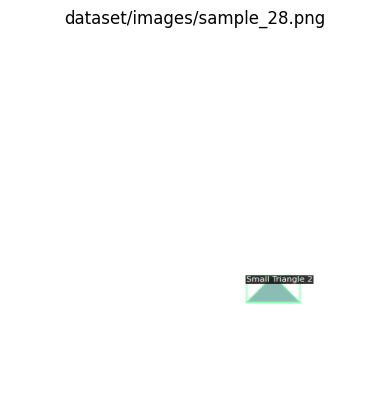

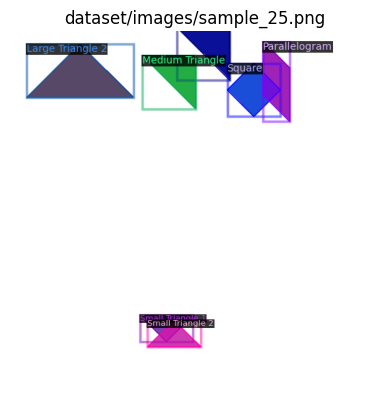

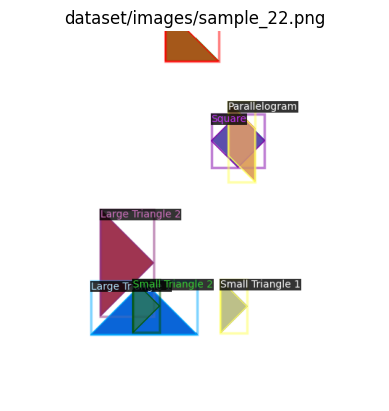

In [19]:
import random
from detectron2.utils.visualizer import Visualizer

# Visualize the dataset
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=tangram_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.title(d["file_name"])
    plt.axis('off')
    plt.show()

In [20]:
# Configure the model
cfg = get_cfg()

# Load the base configuration for Mask R-CNN
cfg.merge_from_file("configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Dataset settings
cfg.DATASETS.TRAIN = ("tangram_train",)
cfg.DATASETS.TEST = ("tangram_test",)

# DataLoader settings
cfg.DATALOADER.NUM_WORKERS = 2

# Pre-trained weights from COCO (detectron2's model zoo)
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"

# Solver settings
cfg.SOLVER.IMS_PER_BATCH = 2  # Adjust based on GPU memory
cfg.SOLVER.BASE_LR = 0.00025  # Learning rate
cfg.SOLVER.MAX_ITER = 100  # Number of iterations
# ROI head settings
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = TANGRAM_NUM  # Ensure this matches dataset categories
# Platform-specific settings
if platform.system() == "Windows":
    cfg.MODEL.DEVICE = "cuda"  # Use CUDA for GPU acceleration on Windows
elif platform.system() == "Darwin":
    cfg.MODEL.DEVICE = "mps"  # Use Metal Performance Shaders on macOS
else:
    cfg.MODEL.DEVICE = "cpu"  # Default to CPU for other platforms
# Create output directory
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/22 10:35:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (7, 256, 1, 1) 

[12/22 10:35:47 d2.engine.train_loop]: Starting training from iteration 0


/opt/homebrew/Caskroom/miniconda/base/envs/tangram/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ERROR [12/22 10:37:24 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/tangram/lib/python3.11/site-packages/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/tangram/lib/python3.11/site-packages/detectron2/engine/defaults.py", line 530, in run_step
    self._trainer.run_step()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/tangram/lib/python3.11/site-packages/detectron2/engine/train_loop.py", line 322, in run_step
    losses.backward()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/tangram/lib/python3.11/site-packages/torch/_tensor.py", line 581, in backward
    torch.autograd.backward(
  File "/opt/homebrew/Caskroom/miniconda/base/envs/tangram/lib/python3.11/site-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/opt/homebrew/Caskroom/miniconda/base/envs/tangram/lib/python3.1

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.